In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
from tensorflow import keras

In [34]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7989691109192298351
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14497349632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 801711612849593267
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"
xla_global_id: 416903419
]


2023-11-21 01:03:03.013717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 01:03:03.555290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-21 01:03:03.561750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-21 01:03:03.562377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be 

### Run setup lines for Sagemaker studio to run properly!
These lines are to ensure that any pushes that you make do not include the raw data files, since they will cause your pushes and commits to fail. Run these lines every time you boot up the instance.

If you're running locally, you only need to run these lines once.

In [ ]:
!apt-get update -y;
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | bash;
!apt-get install git-lfs git -y;
;

# LSTM Proof of Concept

Before we jump straight into using LSTMs to help us handle real-time 5-minute prediction, let's try getting the bare-bones of the model running!

To do this, we will first utilize hourly aggregate data, so that we're not giving DeepNote a complete meltdown.

In [29]:
raw_data = pd.read_csv("~/renewable_power/data-files/CAISO_data.csv")
raw_data = raw_data.drop("Unnamed: 0", axis=1)

In [32]:
data = raw_data.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp') # Next line requires DateTimeIndex to function properly
data = data.resample('H').mean() # This functions like a groupby statement on hour

# Sort by time for readability
data = data.reset_index().sort_values('timestamp', ascending=True).set_index('timestamp') 
data.head()

/tmp/ipykernel_83/3291704442.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.resample('H').mean() # This functions like a groupby statement on hour


,load_MW
timestamp,
2015-01-01 08:00:00+00:00,22499.500000
2015-01-01 09:00:00+00:00,21643.500000
2015-01-01 10:00:00+00:00,21065.000000
2015-01-01 11:00:00+00:00,20665.416667
2015-01-01 12:00:00+00:00,20641.666667


In [35]:
len(data)

70128

In [43]:
# Convert data to proper format for training
def create_dataset(dataset, look_back=1):
    """
    Returns two numpy arrays corresponding to the 
    features to train on and their corresponding labels, respectively.

    Inputs:
        dataset: raw training data with time as index and rows as electricity demand
        look_back: how far back we would like our model to look back to make the next prediction
    """
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1024 # Number of previous hours to consider
X, Y = create_dataset(data['load_MW'].to_numpy().reshape([len(data), 1]), look_back)

# There are some NaNs in our data, removing them for simplicity
unclean_dataset = pd.DataFrame(X)
unclean_dataset['y'] = Y
clean_dataset = unclean_dataset[unclean_dataset.isna().sum(axis=1) == 0]

# ...like there were never any NaNs to begin with :D
Y = clean_dataset['y'].to_numpy()
X = clean_dataset.drop('y', axis=1).to_numpy()

# Splitting the dataset into Training and Test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train_X, test_X = X[0:train_size], X[train_size:len(X)]
train_Y, test_Y = Y[0:train_size], Y[train_size:len(Y)]

In [53]:
pd.DataFrame(train_X[:, :, 0])

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,22499.500000,21643.500000,21065.000000,20665.416667,20641.666667,21061.500000,21796.916667,22032.000000,22234.416667,22125.250000,...,23613.083333,24930.666667,25228.083333,25466.166667,25763.166667,25800.333333,25852.500000,26374.916667,26729.300000,26831.916667
1,21643.500000,21065.000000,20665.416667,20641.666667,21061.500000,21796.916667,22032.000000,22234.416667,22125.250000,21913.750000,...,24930.666667,25228.083333,25466.166667,25763.166667,25800.333333,25852.500000,26374.916667,26729.300000,26831.916667,27147.333333
2,21065.000000,20665.416667,20641.666667,21061.500000,21796.916667,22032.000000,22234.416667,22125.250000,21913.750000,21652.083333,...,25228.083333,25466.166667,25763.166667,25800.333333,25852.500000,26374.916667,26729.300000,26831.916667,27147.333333,28420.333333
3,20665.416667,20641.666667,21061.500000,21796.916667,22032.000000,22234.416667,22125.250000,21913.750000,21652.083333,21243.333333,...,25466.166667,25763.166667,25800.333333,25852.500000,26374.916667,26729.300000,26831.916667,27147.333333,28420.333333,29501.833333
4,20641.666667,21061.500000,21796.916667,22032.000000,22234.416667,22125.250000,21913.750000,21652.083333,21243.333333,20922.416667,...,25763.166667,25800.333333,25852.500000,26374.916667,26729.300000,26831.916667,27147.333333,28420.333333,29501.833333,28909.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45393,24074.200833,25006.578333,25545.596667,24895.512500,23483.359167,21737.026667,20596.540833,19780.216667,19384.734167,19244.879167,...,24621.597500,23409.271667,22476.651667,22023.792500,22201.205833,22892.644167,23862.405000,25029.236667,26046.740000,26227.400000
45394,25006.578333,25545.596667,24895.512500,23483.359167,21737.026667,20596.540833,19780.216667,19384.734167,19244.879167,19561.785000,...,23409.271667,22476.651667,22023.792500,22201.205833,22892.644167,23862.405000,25029.236667,26046.740000,26227.400000,26677.203333
45395,25545.596667,24895.512500,23483.359167,21737.026667,20596.540833,19780.216667,19384.734167,19244.879167,19561.785000,20594.527500,...,22476.651667,22023.792500,22201.205833,22892.644167,23862.405000,25029.236667,26046.740000,26227.400000,26677.203333,27429.909167
45396,24895.512500,23483.359167,21737.026667,20596.540833,19780.216667,19384.734167,19244.879167,19561.785000,20594.527500,21812.035833,...,22023.792500,22201.205833,22892.644167,23862.405000,25029.236667,26046.740000,26227.400000,26677.203333,27429.909167,28128.245000


In [46]:
# Reshape input to be [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

keras.backend.clear_session()
# Create and fit the LSTM network
model3 = keras.Sequential()
model3.add(keras.Input(shape=(look_back, 1)))
model3.add(LSTM(100, input_shape=(look_back, 1)))
model3.add(Dense(10, activation='relu'))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='sgd')

In [47]:
# Proof of concept: checking to see if the model errors or yields erroneous results
model3.fit(train_X[:, :, :], train_Y[:], epochs=100, batch_size=32, verbose=1)

Epoch 1/100
1419/1419 [==============================] - 46s 31ms/step - loss: 10713947136.0000
Epoch 2/100
1419/1419 [==============================] - 44s 31ms/step - loss: 26486008.0000
Epoch 3/100
1419/1419 [==============================] - 44s 31ms/step - loss: 26485492.0000
Epoch 4/100
1419/1419 [==============================] - 44s 31ms/step - loss: 26481046.0000
Epoch 5/100
1419/1419 [==============================] - 44s 31ms/step - loss: 26483750.0000
Epoch 6/100
 115/1419 [=>............................] - ETA: 40s - loss: 27620948.0000

KeyboardInterrupt: 

In [ ]:
# np.sqrt(model3.history.history['loss'])

In [48]:
# RMSE from running one epoch
np.sqrt(model3.history.history['loss'])

array([103508.19839993,   5146.45586788,   5146.40573605,   5145.97376596,
         5146.23648893])

In [41]:
train_Y[:5000]

array([22021.91666667, 21077.33333333, 20483.08333333, ...,
       26970.16666667, 28698.08333333, 30466.25      ])

In [49]:
train_predict = model3.predict(train_X[:5000, :, :])
pd.DataFrame(train_predict)

157/157 [==============================] - 2s 12ms/step


,0
0,24895.173828
1,24895.173828
2,24895.173828
3,24895.173828
4,24895.173828
...,...
4995,24895.173828
4996,24895.173828
4997,24895.173828
4998,24895.173828


(array([  486., 14066., 17391., 13258.,  4917.,  2628.,  1699.,   832.,
          242.,    28.]),
 array([14104.4425    , 17606.08991667, 21107.73733333, 24609.38475   ,
        28111.03216667, 31612.67958333, 35114.327     , 38615.97441667,
        42117.62183333, 45619.26925   , 49120.91666667]),
 <BarContainer object of 10 artists>)

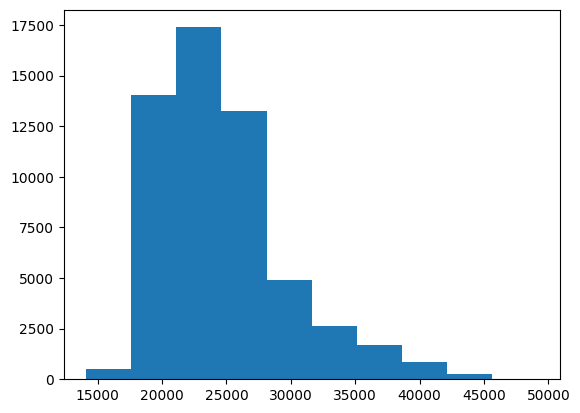

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train_Y)

In [ ]:
# Make predictions
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# Invert predictions
train_Y, test_Y = Y[0:train_size], Y[train_size:len(Y)]
train_predict = scaler.inverse_transform(train_predict)
train_Y = scaler.inverse_transform([train_Y])
test_predict = scaler.inverse_transform(test_predict)
test_Y = scaler.inverse_transform([test_Y])

def mse(predicted, actual):
    return np.mean((predicted - actual) ** 2)

# Calculate root mean squared error
train_score = np.sqrt(mse(train_Y[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = np.sqrt(mse(test_Y[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

1150/1752 [==================>...........] - ETA: 10s

KeyboardInterrupt: 

In [ ]:
# Plotting baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(np.concatenate((train_predict, test_predict)))
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b82b9643-cfd7-4eed-98d3-bc210272c836' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>